# Deep Switching Autoregresive Factorization (DSARF)

DSARF package is an easy-to-use implementation of our [AAAI'21 paper](https://arxiv.org/pdf/2009.05135.pdf) which can be used for training, testing, and visulization in just few lines of code ([check Documentation here](./Documentation.ipynb)). In this notebook, we show how to use DSARF for short- and long-term prediction and state estimation on several vector time series datasets.

In [1]:
from dsarf import DSARF
from dsarf import compute_NRMSE
import numpy as np
import torch
import seaborn as sns
torch.manual_seed(10)
np.random.seed(10)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.signal import medfilt
import copy
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Example 1 : Figure 8 dataset

In [2]:
f8_data = np.load('fig8_data.npy')
T, J, D = f8_data.shape

### Plot the data

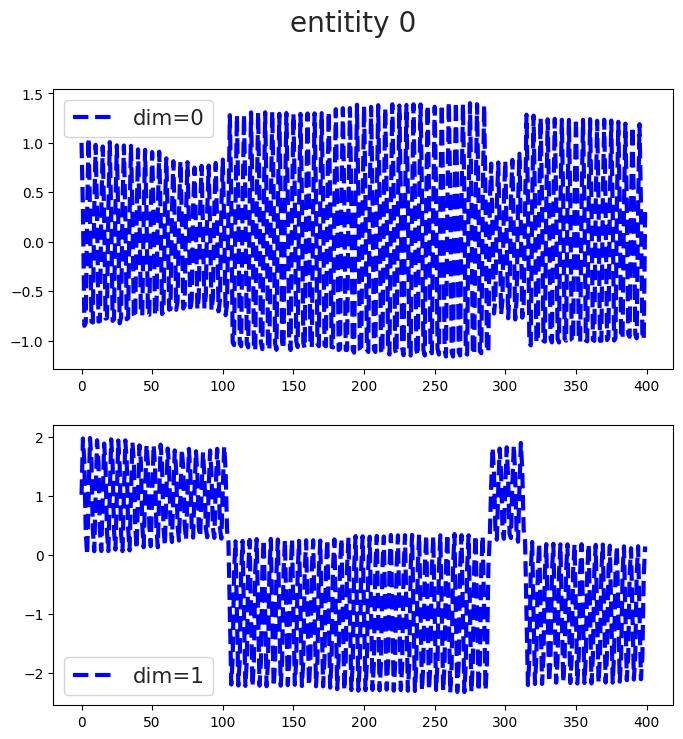

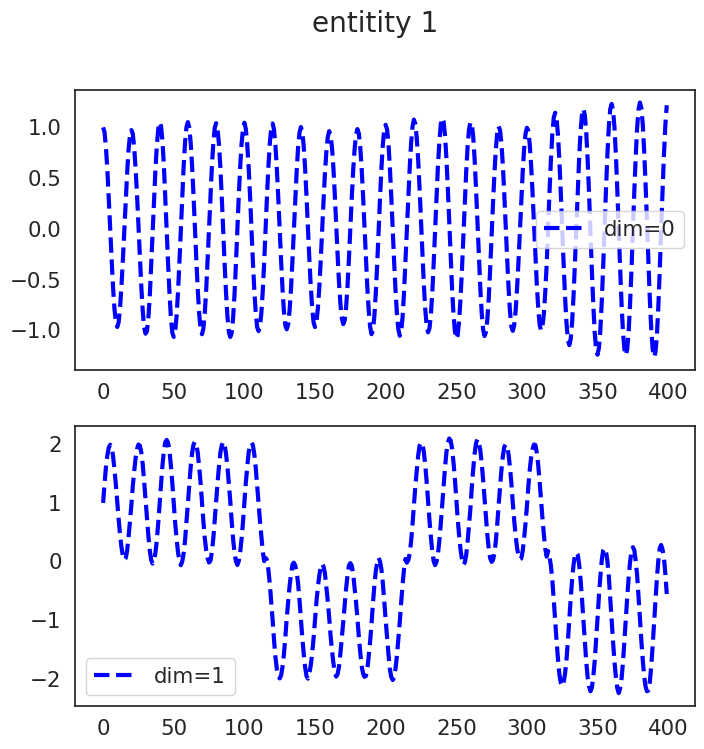

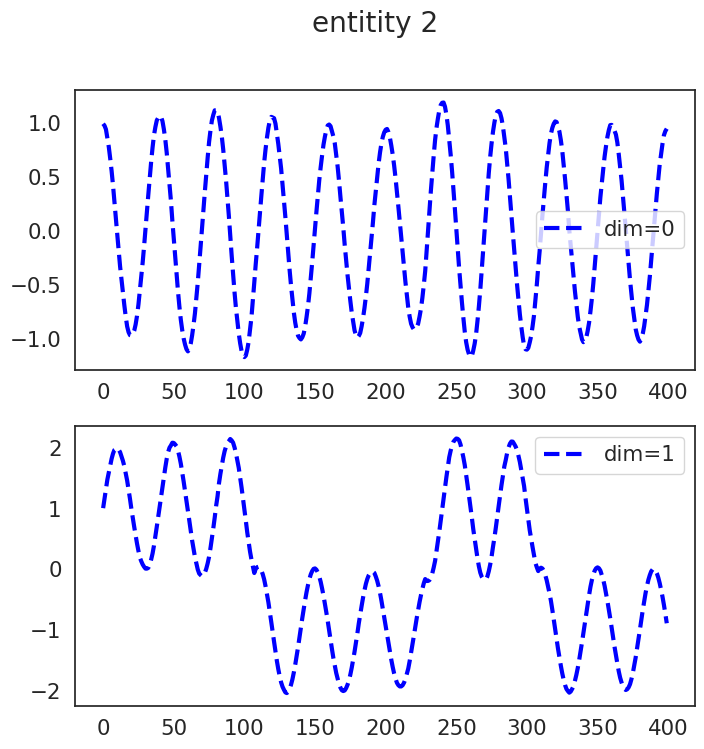

In [3]:
for j in range(J):
    f, axs = plt.subplots(D, 1, figsize=(8, 8))
    sns.set_context('notebook', font_scale=1.4)
    sns.set_style('white')
    lw=3
    t = range(T)
    for d in range(D):
        axs[d].plot(t, f8_data[:, j, d], 'b--', label='dim=%s'%d, linewidth=lw)
        axs[d].legend()
    f.suptitle('entitity %s'%j)
plt.show()

## Case 1 : Complete Independence long term prediction

Using device: cpu
Total Number of Parameters: 9243
Learnable Parameters: 7843


  0%|          | 0/300 [00:00<?, ?it/s]

Using device: cpu, Epoch 300: {NRMSE_recv : 1.71, NRMSE_pred : 5.17}}}}
Total Number of Parameters: 9243
Learnable Parameters: 7843


  0%|          | 0/300 [00:00<?, ?it/s]

Using device: cpu, Epoch 300: {NRMSE_recv : 1.88, NRMSE_pred : 3.22}}}
Total Number of Parameters: 9243
Learnable Parameters: 7843


  0%|          | 0/300 [00:00<?, ?it/s]

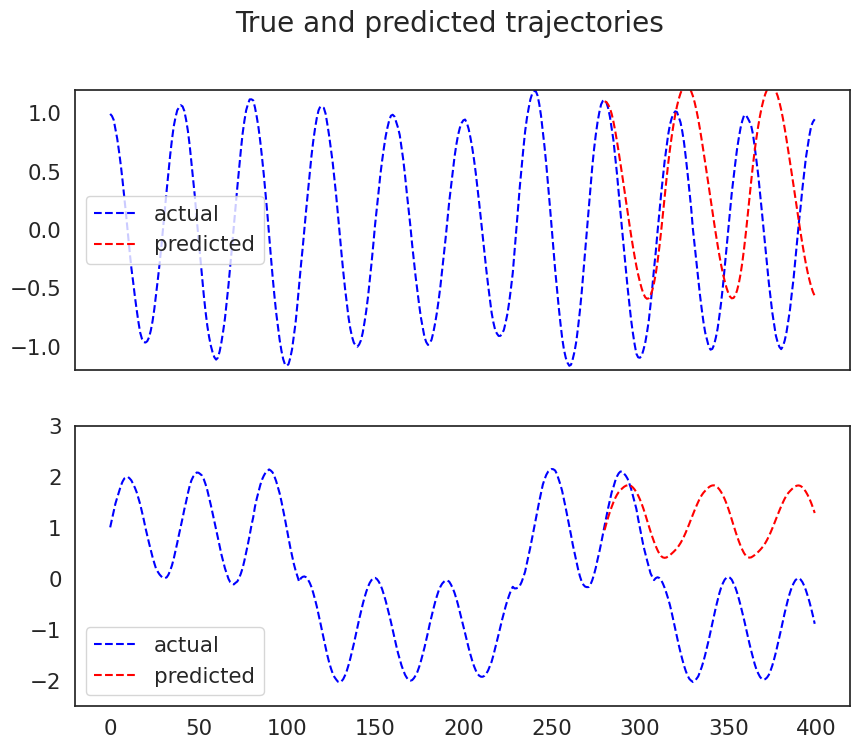

In [7]:
# remove the last 120 time points in the 3rd entity
downsampling_factor = 1
f8_data_ds = f8_data[::downsampling_factor, :, :]
f8_data_ds_ent_3 = f8_data_ds[::downsampling_factor, 2, :].copy()

f8_data_ds_ent_3_cropped = f8_data_ds_ent_3[:280, :]
f8_data_ds_ent_3_masked = f8_data_ds[::downsampling_factor, 2, :].copy()
f8_data_ds_ent_3_masked[280:, :]=np.nan
n_states = 5#2
factor_dim = 8#3

data_eval = [f8_data_ds_ent_3]
y_true = data_eval[0]

lags = [1, 2]
data_train = [f8_data_ds_ent_3_cropped]
t_train = np.arange(0, 400)
t_pred = np.arange(280, 400)
torch.manual_seed(41)## required for reproducilibility
dsarf = DSARF(D, factor_dim=factor_dim, L=lags, S=n_states, batch_size=1, 
              recursive_state = True, lr=0.05)


seed_list = [41, 52, 109]
# seed_list = [523]
y_pred_samples_forecast_list = []
perf_per_seed_list = []

for seed in seed_list: 

    # set random seed for reproducibility
    torch.manual_seed(seed)
    
    model_train, fit_perf = dsarf.fit(data_train, epoch_num = 300, 
                                      return_stats=True)
    
    y_pred = model_train.long_predict(steps=120)
    
    y_pred_samples_forecast_list.append(y_pred)
    perf_per_seed_list.append(fit_perf)

# choose the model with the least elbo loss
elbo_loss_per_seed = [ii['loss'] for ii in perf_per_seed_list]
best_ind = np.argmin(elbo_loss_per_seed)

y_pred_mu, y_pred_p, y_pred_n = y_pred_samples_forecast_list[best_ind]

y_pred = y_pred_mu[0]
n_dims = y_true.shape[1]

f, axs = plt.subplots(n_dims, figsize=(10, 8), sharex=True)
for ii in range(n_dims):
    axs[ii].plot(t_train, y_true[:, ii], 'b--', label='actual')
    axs[ii].plot(t_pred, y_pred[:, ii], 'r--', label='predicted')

    axs[ii].legend()
axs[0].set_ylim([-1.2, 1.2])
axs[1].set_ylim([-2.5, 3.0])
f.suptitle('True and predicted trajectories') 
plt.show()
    

## Case 2 : Multi-channel long term prediction

Training with seed : 41
Using device: cpu
Total Number of Parameters: 18797
Learnable Parameters: 16797


  0%|          | 0/2000 [00:00<?, ?it/s]

Using device: cpu, Epoch 2000: {NRMSE_recv : 1.77, NRMSE_pred : 18.11}}}
Total Number of Parameters: 15797
Learnable Parameters: 5825


  0%|          | 0/200 [00:00<?, ?it/s]

Training with seed : 52h 200: {NRMSE_recv : 3.34, NRMSE_pred : 17.31}}}
Using device: cpu
Total Number of Parameters: 18797
Learnable Parameters: 16797


  0%|          | 0/2000 [00:00<?, ?it/s]

Using device: cpu, Epoch 2000: {NRMSE_recv : 1.68, NRMSE_pred : 19.87}}}}
Total Number of Parameters: 15797
Learnable Parameters: 5825


  0%|          | 0/200 [00:00<?, ?it/s]

Training with seed : 109 200: {NRMSE_recv : 3.51, NRMSE_pred : 18.56}}}
Using device: cpu
Total Number of Parameters: 18797
Learnable Parameters: 16797


  0%|          | 0/2000 [00:00<?, ?it/s]

Using device: cpu, Epoch 2000: {NRMSE_recv : 1.71, NRMSE_pred : 20.11}}
Total Number of Parameters: 15797
Learnable Parameters: 5825


  0%|          | 0/200 [00:00<?, ?it/s]

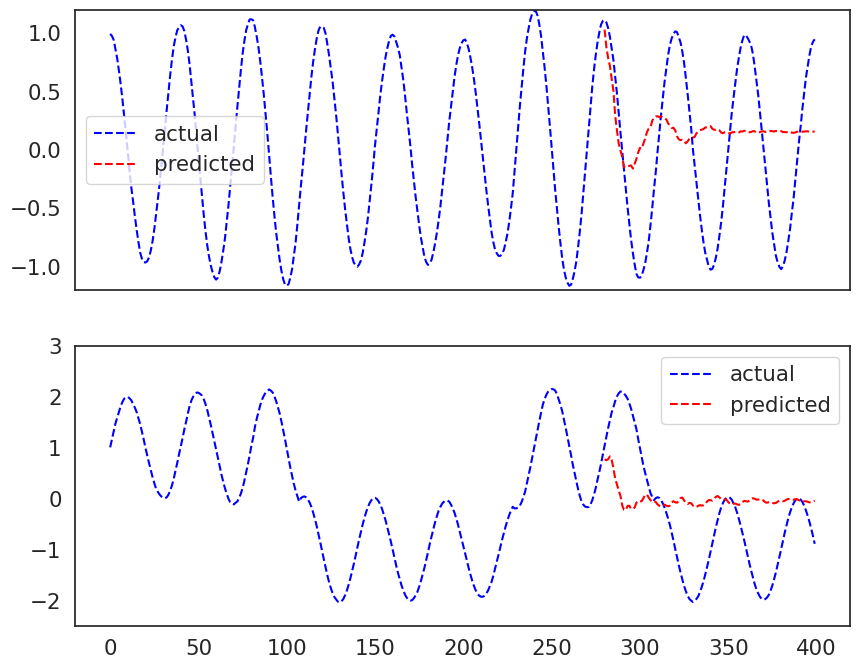

Text(0.5, 0.98, 'True and predicted trajectories')

In [8]:
##### multi channel prediction
f8_data = np.load('fig8_data.npy')
downsampling_factor = 1
f8_data_ds = f8_data[::downsampling_factor, :, :]
f8_data_ds_ent_3 = f8_data_ds[::downsampling_factor, 2, :].copy()
T, J, D = f8_data_ds.shape
seed_list = [41, 52, 109]
data_eval = [f8_data_ds_ent_3]
y_true = data_eval[0]

f8_data_ds_cropped = f8_data_ds[:280, :, :].copy()
f8_data_ds_masked = f8_data_ds.copy()
f8_data_ds_masked[280:, 2, :]=np.nan

T_train = f8_data_ds_cropped.shape[0]
data_train_cropped = [f8_data_ds_cropped.reshape(T_train, J*D)]

T_train = f8_data_ds_masked.shape[0]
data_train_masked = [f8_data_ds_masked.reshape(T_train, J*D)]

t_train = np.arange(0, 400)
t_pred = np.arange(280, 400)

data_eval = [f8_data_ds_ent_3]
perf_per_seed_list = []
y_pred_samples_forecast_list_multi_channel = []


steps=120
for seed in seed_list: 
    print('Training with seed : %d'%seed)
    
    # set random seed for reproducibility
    torch.manual_seed(seed)

    dsarf = DSARF(J*D, 
                  factor_dim =10,#10 
                  L=[1,2,10, 11], 
                  S=5,#2 
                  batch_size=1, lr=0.05)
    model_train_forecast, fit_perf = dsarf.fit(data_train_masked, 2000, 
                                               return_stats=True)
    
    model_forecast = dsarf.infer(data_train_cropped, 200)
    
    if steps is None:
        y_pred = model_forecast.short_predict()
    else:
        y_pred = model_forecast.long_predict(steps)
        
    y_pred_samples_forecast_list_multi_channel.append(y_pred)
    perf_per_seed_list.append(fit_perf)
    
elbo_loss_per_seed = [ii['loss'] for ii in perf_per_seed_list]
best_ind = np.argmin(elbo_loss_per_seed)

y_pred_mu, y_pred_p, y_pred_n = y_pred_samples_forecast_list_multi_channel[best_ind]

# plot
y_pred = y_pred_mu[0]
n_dims = y_true.shape[1]
f, axs = plt.subplots(n_dims, figsize=(10, 8), sharex=True)
for ii, dd in enumerate([4, 5]):
    axs[ii].plot(t_train, y_true[:, ii], 'b--', label='actual')
    axs[ii].plot(t_pred, y_pred[:, dd], 'r--', label='predicted')

    axs[ii].legend()
axs[0].set_ylim([-1.2, 1.2])
axs[1].set_ylim([-2.5, 3.0])
plt.show()
f.suptitle('True and predicted trajectories')  

## Case 3 : Complete Pooling long term prediction

Using device: cpu
Total Number of Parameters: 30617
Learnable Parameters: 28217


  0%|          | 0/1000 [00:00<?, ?it/s]

Using device: cpu, Epoch 1000: {NRMSE_recv : 3.26, NRMSE_pred : 8.87}}
Total Number of Parameters: 22697
Learnable Parameters: 17466


  0%|          | 0/500 [00:00<?, ?it/s]

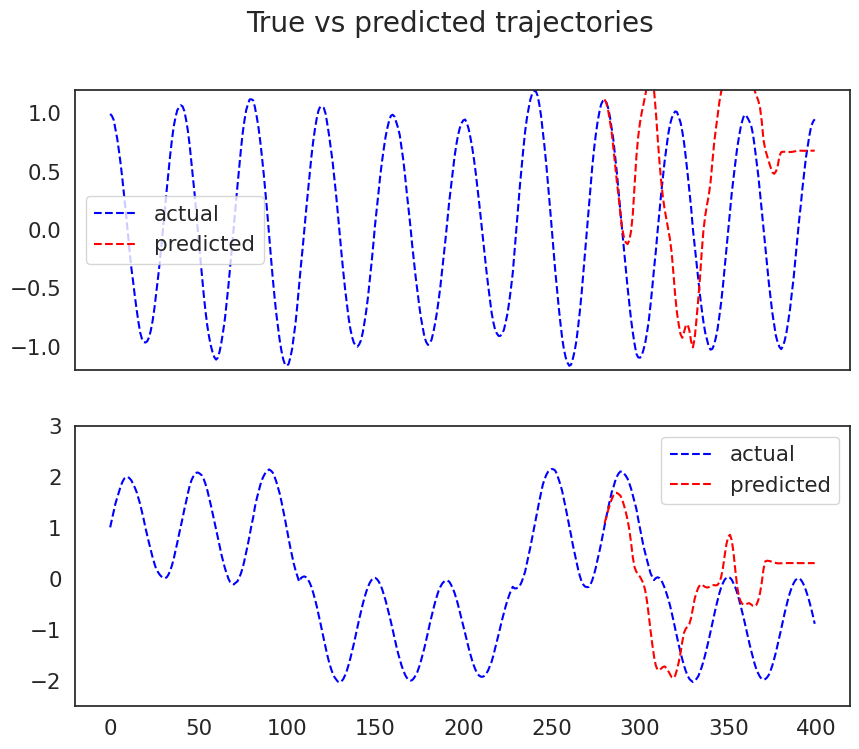

In [94]:
##### complete pooling
f8_data = np.load('fig8_data.npy')
downsampling_factor = 1
f8_data_ds = f8_data[::downsampling_factor, :, :]
T, J, D = f8_data_ds.shape
seed_list = [523]
y_pred_samples_forecast_list_complete_pooling = []

# remove the last 120 time points in the 3rd entity
f8_data_ds_masked = f8_data_ds.copy()
f8_data_ds_masked[280:, 2, :]=np.nan


f8_data_ds_cropped = f8_data_ds[:280, :, :].copy()
T_train = f8_data_ds_cropped.shape[0]
data_train_cropped = [f8_data_ds_cropped[:, jj, :] for jj in range(J)]
data_train_masked = [f8_data_ds_masked[:, jj, :] for jj in range(J)]

steps=120#None
perf_per_seed_list = []
entity_id=2
for seed in seed_list: 
    seed = seed

    # set random seed for reproducibility
    torch.manual_seed(seed)

    dsarf = DSARF(D, factor_dim=10, L=[1,2,10,11], 
                  S=2, batch_size=1, lr=0.05)
    model_train_forecast, fit_perf = dsarf.fit(data_train_masked, 1000, 
                                               return_stats=True)
    model_forecast = dsarf.infer(data_train_cropped, 500)
    
    if steps is None:
        y_pred = model_forecast.short_predict()
    else:
        y_pred = model_forecast.long_predict(steps)
        
    y_pred_samples_forecast_list_complete_pooling.append(y_pred)
    perf_per_seed_list.append(fit_perf)

elbo_loss_per_seed = [ii['loss'] for ii in perf_per_seed_list]
best_ind = np.argmin(elbo_loss_per_seed)

y_pred_mu, y_pred_p, y_pred_n = y_pred_samples_forecast_list_complete_pooling[best_ind]


y_pred = y_pred_mu[entity_id]
n_dims = y_true.shape[1]

f, axs = plt.subplots(n_dims, figsize=(10, 8), sharex=True)
for ii in range(n_dims):
    axs[ii].plot(t_train, y_true[:, ii], 'b--', label='actual')
    axs[ii].plot(t_pred, y_pred[:, ii], 'r--', label='predicted')

    axs[ii].legend()
axs[0].set_ylim([-1.2, 1.2])
axs[1].set_ylim([-2.5, 3.0])
f.suptitle('True vs predicted trajectories') 
plt.show()